# 实验一
自定义Inception网络，并在Kaggle猫/狗数据集上进行训练和测试
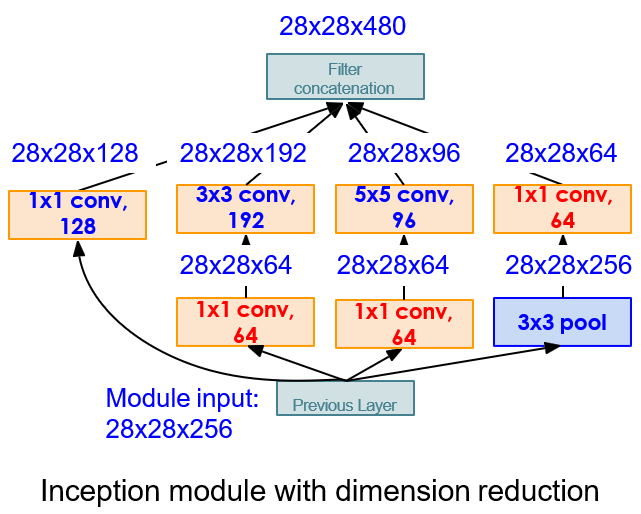

## 1.加载keras模块

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, AveragePooling2D,Input,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense,Concatenate
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
import numpy as np

### 定义Inception网络结构



In [8]:
img_width, img_height = 50, 50

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
    bn_axis = 1   # 
else:
    input_shape = (img_width, img_height, 3)
    bn_axis = 3
    
#声明Input layer并设置input_shape 
x = Input(shape = input_shape)  
      
#以函数形式定义inception module的分支，可适当比上图inception结构减少滤波器个数
'''Inception结构将不同的卷积层通过并联的方式结合在一起。同时使用所有不同尺寸的过滤器，然后再将得到的矩阵拼接起来。
不同的矩阵代表了Inception模型中的一条计算路径。虽然过滤器的大小不同，但如果所有的过滤器都使用全0填充且步长为1，
那么前向传播得到的结果矩阵的长和宽都与输入矩阵一致。这样经过不同过滤器处理的结果矩阵可以拼接成一个更深的矩阵。
'''
#branch 1
branch1_out = Conv2D(16, (1, 1),padding="same",use_bias=False)(x)  
branch1_out = BatchNormalization(axis=bn_axis)(branch1_out)
branch1_out = Activation('relu')(branch1_out)

#branch 2   
branch2_out = Conv2D(16, (1, 1),padding="same",use_bias=False)(x)
branch2_out = BatchNormalization(axis=bn_axis)(branch2_out)
branch2_out = Activation('relu')(branch2_out)  

branch2_out = Conv2D(48, (3, 3),padding="same",use_bias=False)(branch2_out)
branch2_out = BatchNormalization(axis=bn_axis)(branch2_out)
branch2_out = Activation('relu')(branch2_out) 


#branch 3
branch3_out = Conv2D(16, (1, 1),padding="same",use_bias=False)(x)
branch3_out = BatchNormalization(axis=bn_axis)(branch3_out)
branch3_out = Activation('relu')(branch3_out)

branch3_out = Conv2D(24, (5, 5),padding="same",use_bias=False)(branch3_out)
branch3_out = BatchNormalization(axis=bn_axis)(branch3_out)
branch3_out = Activation('relu')(branch3_out) 

#branch 4
branch4_out = AveragePooling2D(pool_size=(3, 3),strides=(1, 1), padding='same', data_format=K.image_data_format())(x)
branch4_out = Conv2D(16, (1, 1),padding="same",use_bias=False)(branch4_out)
branch4_out = BatchNormalization(axis=bn_axis)(branch4_out)
branch4_out = Activation('relu')(branch4_out)

#以函数形式定义inception module的concatenate layer
out = Concatenate(axis=bn_axis)([branch1_out, branch2_out, branch3_out, branch4_out])

#为减少网络规模，可使用1*1 conv layer压缩feature map深度
out = Conv2D(16, (1, 1),padding="same",use_bias=False)(out)

#定义fully connected layer
out = Flatten()(out)
out = Dense(48, activation='relu')(out)

#定义output layer
out = Dense(1, activation='sigmoid')(out)

#调用Model函数声明model
model = Model(x, out)


#编译整个网络，声明loss函数和优化器、metrics
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### 查看model架构



In [9]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 50, 50, 16)   48          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 50, 50, 16)   48          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 50, 50, 16)   64          conv2d_9[0][0]                   
____________________________________________________________________________________________

### 定义ImageDataGenerator


In [10]:
train_data_dir = r'C:/Users/H/Desktop/AI/11.6/dogs-vs-cats/train'
validation_data_dir = r'C:/Users/H/Desktop/AI/11.6/dogs-vs-cats/validation'
nb_train_samples = 10835
nb_validation_samples = 4000
epochs = 1
batch_size = 5


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

#调用flow_from_directory函数读取training数据和validation数据，注意
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')



Found 10835 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


### 训练模型



In [11]:
#调用fit_generator函数
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/1
2167/2167 [==============================] - 288s 133ms/step - loss: 0.7417 - accuracy: 0.6036 - val_loss: 0.7973 - val_accuracy: 0.6072


### 使用训练后模型预测图像

In [12]:
import cv2
img = cv2.resize(cv2.imread(r'C:/Users/H/Desktop/AI/11.6/dogs-vs-cats/test/7.jpg'), (img_width, img_height)).astype(np.float32)
# img[:,:,0] -= 103.939
# img[:,:,1] -= 116.779
# img[:,:,2] -= 123.68
#img = img.transpose((2,0,1))
x = img_to_array(img)

x = np.expand_dims(x, axis=0)

#x = preprocess_input(x)

score = model.predict(x)


print(score)

[[1.]]
